In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import tsfel

fs = 1000

def is_rest(x):
    return ((31 * fs < x) & (x < 59 * fs) |
            (91 * fs < x) & (x < 119 * fs) |
            (151 * fs < x) & (x < 179 * fs) |
            (211 * fs < x) & (x < 239 * fs) |
            (271 * fs < x) & (x < 299 * fs) |
            (331 * fs < x) & (x < 359 * fs))


def is_medium(x):
    return ((61 * fs < x) & (x < 89 * fs) |
            (121 * fs < x) & (x < 149 * fs) |
            (181 * fs < x) & (x < 209 * fs))


def is_high(x):
    return ((241 * fs < x) & (x < 269 * fs) |
            (301 * fs < x) & (x < 329 * fs) |
            (361 * fs < x) & (x < 389 * fs))

In [2]:
path_pedro = 'data pedro/opensignals_spo2_pedro_2021-12-03_15-16-47.txt'
path_rodrigo = 'data pedro/opensignals_spo2_rodrigo_2021-12-03_14-57-47.txt'
path_diogo = 'data pedro/opensignals_spo2_diogo_2021-12-03_15-08-49.txt'

data_pedro = pd.read_csv(path_pedro, delim_whitespace=True,
                         header=0, names=["nSeq", "DI", "CH9A", "CH9B", "SpO2"],
                         skiprows=3, usecols=("nSeq", "CH9A", "CH9B", "SpO2"))
data_rodrigo = pd.read_csv(path_rodrigo, delim_whitespace=True,
                           header=0, names=["nSeq", "DI", "CH9A", "CH9B", "SpO2"],
                           skiprows=3, usecols=("nSeq", "CH9A", "CH9B", "SpO2"))
data_diogo = pd.read_csv(path_diogo, delim_whitespace=True,
                         header=0, names=["nSeq", "DI", "CH9A", "CH9B", "SpO2"],
                         skiprows=3, usecols=("nSeq", "CH9A", "CH9B", "SpO2"))
df = data_pedro.copy()

df['state'] = 'default'
df['state'] = np.where(is_rest(df['nSeq']), 'rest_pressure', df['state'])
df['state'] = np.where(is_medium(df['nSeq']), 'medium_pressure', df['state'])
df['state'] = np.where(is_high(df['nSeq']), 'high_pressure', df['state'])

df = df.drop(df[df['state'] == 'default'].index)

df_rest = df[df['state'] == 'rest_pressure']
df_medium = df[df['state'] == 'medium_pressure']
df_high = df[df['state'] == 'high_pressure']

# CH9A : Red light channel
# CH9B : IR light channel

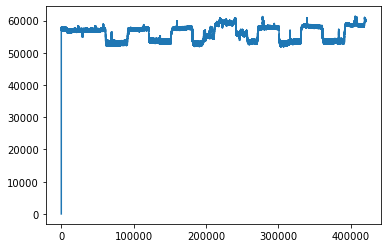

          nSeq   CH9A   CH9B  SpO2
0            1      0      0     0
1            2  57814  57910     0
2            3  57814  57910     0
3            4  57969  58558     0
4            5  57969  58558     0
...        ...    ...    ...   ...
420894  420895  60441  61122    84
420895  420896  60441  61122    84
420896  420897  60512  60883    84
420897  420898  60512  60883    84
420898  420899  60091  60443    84

[420899 rows x 4 columns]


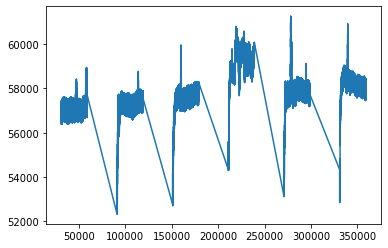

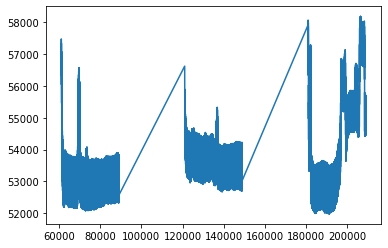

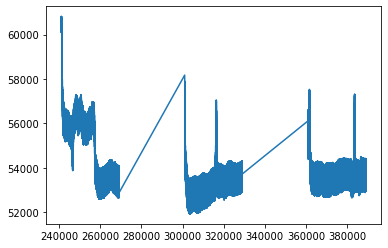

In [3]:
plt.figure()
plt.plot(data_pedro['CH9A'])
plt.show()
print(data_pedro)

plt.figure()
plt.plot(df_rest['CH9A'])
plt.show()
plt.figure()
plt.plot(df_medium['CH9A'])
plt.show()
plt.figure()
plt.plot(df_high['CH9A'])
plt.show()

151000    52763
151001    52763
151002    53236
151003    53236
151004    54182
          ...  
178995    57790
178996    57790
178997    58281
178998    58281
178999    58038
Name: CH9A, Length: 28000, dtype: int64


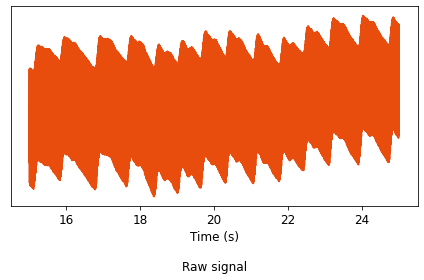

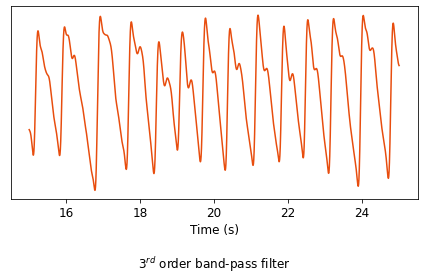

In [4]:
df_rest2 = data_pedro['CH9A'][151 * fs:179 * fs]
time=np.linspace(0,28,28*fs)

start = 15
end = 25

print(df_rest2)
plt.figure()
plt.plot(time[start*fs:end*fs],df_rest2[start*fs:end*fs], color='#E84D0E')
# plt.xlabel('Time (s)', fontsize=12)
plt.xlabel('Time (s)\n\nRaw signal', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks([])
plt.tight_layout()
# plt.savefig('../before_filter.pdf')
# plt.savefig('../before_filter_apresentacao.png', dpi=1000)
plt.show()

# Filtrado
plt.figure()
low_cut = 0.5 / (0.5*fs)
high_cut = 10 / (0.5*fs)

b, a = signal.butter(3, [low_cut, high_cut], btype='band')

result = signal.filtfilt(b,a,df_rest2)

plt.plot(time[start*fs:end*fs],result[start*fs:end*fs], color='#E84D0E')
# plt.xlabel('Time (s)', fontsize=12)
plt.xlabel('Time (s)\n\n3$^{rd}$ order band-pass filter', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks([])
plt.tight_layout()
# plt.savefig('../after_filter.pdf')
# plt.savefig('../after_filter_apresentacao.png', dpi=1000)
plt.show()

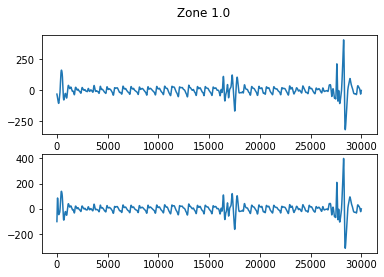

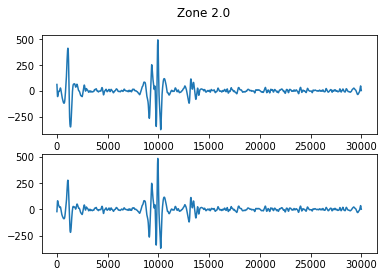

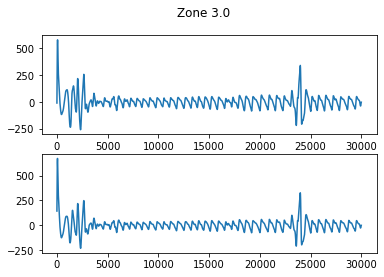

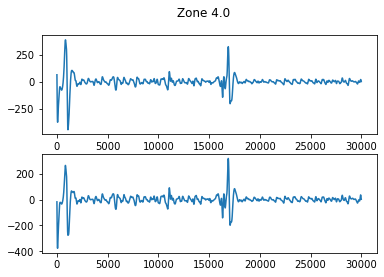

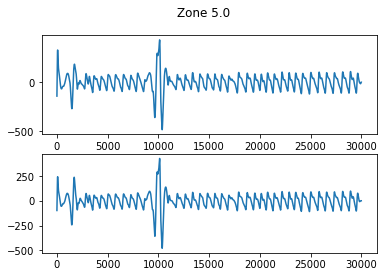

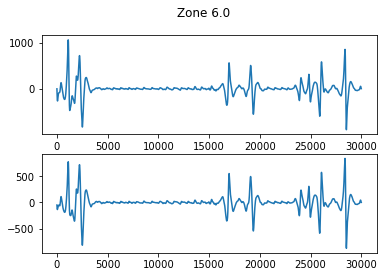

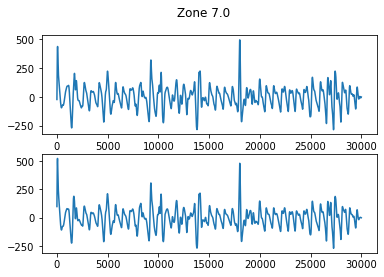

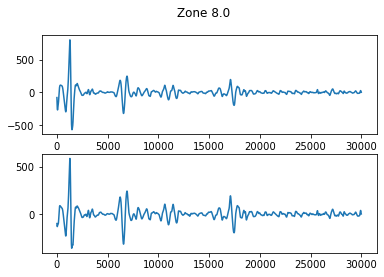

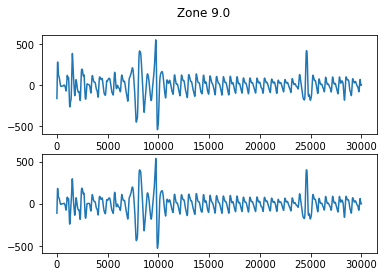

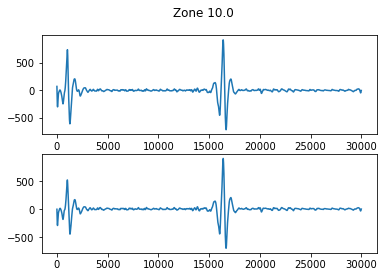

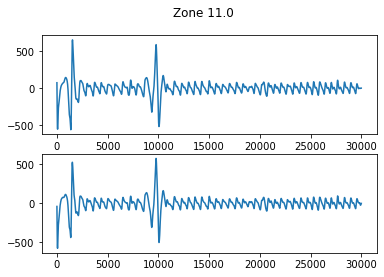

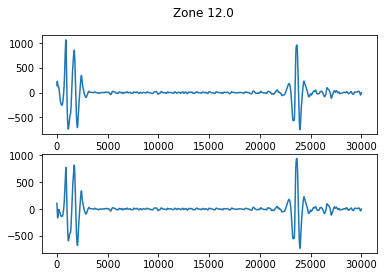

In [46]:
# Separar por zonas
df_zone = data_pedro.copy()
df_zone['zone'] = 'default'

for i in range(30,390,30):
#     df_zone['zone'][i*fs:(i+30)*fs+1] = 'zone' + str(i/30)
    df_zone.loc[(df_zone.nSeq > i*fs), 'zone'] = i/30

# Zones after zone 12 need to be deleted
df_zone.loc[(df_zone.nSeq > 390*fs), 'zone'] = 'default'
    
df_zone = df_zone.drop(df_zone[df_zone['zone'] == 'default'].index)

df_filtered = pd.DataFrame(columns = ['CH9A', 'CH9B', 'zone'])

def processing(channel, zone):
    df_zona = df_zone.loc[df_zone['zone'] == zone][channel].copy()
    
#     # Tirar outliers
#     df_out = df_zona[df_zona.between(
#         df_zona.mean() - 2 * df_zona.std(), 
#         df_zona.mean() + 2 * df_zona.std())]
    df_out=df_zona
    
#     # Normalize
#     # Using min-max
#     df_normal=(df_out - df_out.min()) / (df_out.max() - df_out.min())
    df_normal = df_out
    
    # FILTRO (1 Hz e 7 Hz)
    low_cut = 1 / (0.5 * fs)
    high_cut = 7 / (0.5 * fs)

    b, a = signal.butter(3, [low_cut, high_cut], btype='band')

    result = signal.filtfilt(b,a,df_normal)
    result_series = pd.Series(result, name=channel)
    
#     # Tirar outliers
#     result_series = result_series[result_series.between(
#         result_series.mean() - 2 * result_series.std(), 
#         result_series.mean() + 2 * result_series.std())]
    
    result = result_series.to_frame().reset_index(drop=True)
    
    return result        
    
# Para cada zona
for zone in df_zone['zone'].unique():
    df_CH9A = processing('CH9A', zone)
    df_CH9B = processing('CH9B', zone)
    result = df_CH9A.join(df_CH9B)
    
    result['zone'] = zone
    df_filtered = pd.concat([df_filtered, result], ignore_index=True)

    # PLOTS
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Zone ' + str(zone))
    ax1.plot(result['CH9A'])
    ax2.plot(result['CH9B'])

# Change the columns names
df_filtered = df_filtered.rename(columns={'CH9A': 'data_R', 'CH9B': 'data_IR'})

# print(df_filtered)
    

#### Separate into blocks and saves figures for visual inspection

In [47]:
window = 3 # fazer janelas de 3 segundos
string = ''

for pressure_zone in df_filtered['zone'].unique():
# for pressure_zone in (1,2):

    data_pressure_zone = df_filtered.loc[df_filtered['zone'] == pressure_zone][['data_R', 'data_IR']].copy()
    
    # Remove 1s on the end and beginning of every pressure situation
    data_pressure_zone = data_pressure_zone[fs:-fs]
    
    data_separated = np.array_split(data_pressure_zone, round(len(data_pressure_zone) / (window*fs)))
    
    i = 0
    
    
    for block in data_separated:
        # Plots for visual inspection
        fig, (ax1, ax2) = plt.subplots(2)
        fig.suptitle('Zone ' + str(pressure_zone) + '; Block ' + str(i))
        ax1.plot(block['data_R'])
        ax2.plot(block['data_IR'])
        fig.savefig('signal quality/zone_' + str(pressure_zone) + '_block_' + str(i) + '.png', dpi=100)
        plt.close() # prevents unnecessary plots
        
        string += 'Zone_' + str(pressure_zone) + ',Block_' + str(i) + ',\n'
        i += 1


#### Quality check

In [57]:
quality_dic = {
    1 : 'high_quality',
    2 : 'medium_quality',
    3 : 'low_quality'
}

with open('quality_check.txt', 'r') as file:
    data = file.readlines()

d = pd.DataFrame(data=0, 
                 index=['low_pressure', 'medium_pressure', 'high_pressure'], 
                 columns=['high_quality', 'medium_quality', 'low_quality'])

df_quality = pd.DataFrame(columns=['zone','block','quality'])
    
for line in data:
    zone, block, quality = line.split(',', 3)
    
    intro_zone, zone = zone.split('_', 1)
    
    zone = int(float(zone))
    dic = {'zone':zone,
           'block':block[-1],
           'quality':quality_dic[float(quality[0])]
          }
    df_quality = df_quality.append(dic, ignore_index = True)
    
    if(zone % 2 == 0): # zona par -> medium ou high pressure
        if(zone > 6): # high pressure
            d.at['high_pressure', dic['quality']] += 1
            dic
        else: # medium pressure
            d.at['medium_pressure', dic['quality']] += 1
    else: # zona impar -> low pressure
        d.at['low_pressure', dic['quality']] += 1
    

    
print(d)
print(df_quality)

                 high_quality  medium_quality  low_quality
low_pressure               27              14           13
medium_pressure             0              12           15
high_pressure               0              13           14
    zone block         quality
0      1     0    high_quality
1      1     1    high_quality
2      1     2    high_quality
3      1     3    high_quality
4      1     4  medium_quality
..   ...   ...             ...
103   12     4  medium_quality
104   12     5  medium_quality
105   12     6     low_quality
106   12     7     low_quality
107   12     8     low_quality

[108 rows x 3 columns]


In [85]:
cfg = tsfel.get_features_by_domain()
f = open('new features/features_all.csv', 'w')

# Write header
temp_df = df_filtered.loc[df_filtered['zone'] == 1][['data_R', 'data_IR']].copy()
temp = np.array_split(temp_df, round(len(temp_df) / (window * fs)))
header_string = ''
header = tsfel.time_series_features_extractor(cfg, temp[0][['data_R', 'data_IR']], fs=fs)
for col in header.columns:
    header_string += col + ','
f.write(header_string + 'state' + '\n')
count = 0
for pressure_zone in df_filtered['zone'].unique():
    
    data_pressure_zone = df_filtered.loc[df_filtered['zone'] == pressure_zone][['data_R', 'data_IR']].copy()
    
    # Remove 1s on the end and beginning of every pressure situation
    data_pressure_zone = data_pressure_zone[fs:-fs]
    
    data_separated = np.array_split(data_pressure_zone, round(len(data_pressure_zone) / (window*fs)))
    
    i = 0
        
    for block in data_separated:
        # Only accept the medium and high quality blocks
        if(len(df_quality.loc[(df_quality.quality != 'low_quality') & 
                              (df_quality.zone == pressure_zone) & 
                              (df_quality.block == str(i))]) > 0):
            
            # Normalizing using min-max
            block['data_R'] = (block['data_R'] - block['data_R'].min()) / (block['data_R'].max() - block['data_R'].min())
            block['data_IR'] = (block['data_IR'] - block['data_IR'].min()) / (block['data_IR'].max() - block['data_IR'].min())

            features = tsfel.time_series_features_extractor(cfg, block[['data_R', 'data_IR']], fs=fs)
            features.to_csv(f, header=False, index=False, line_terminator=',')

            if(pressure_zone % 2 == 0): # zona par -> medium ou high pressure
                f.write('pressure' + '\n')
            else: # zona impar -> low pressure
                f.write('no_pressure' + '\n')
            
            count += 1
        i +=1

            
f.close()
print('Count:',count)

*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
66
